# About
- Load transcript data
- Create and persist a chromadb

# Step 1: Import Libraries and Settings

In [1]:
import pandas as pd
import os
import seaborn as sns
from dotenv import load_dotenv
import torch

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


load_dotenv()
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [2]:
!nvidia-smi

Fri Nov  8 14:09:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              3W /   68W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print(torch.__version__)

use_cuda = torch.cuda.is_available()
print("CUDA available:",use_cuda)
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

2.3.1+cu118
CUDA available: True
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
__CUDA Device Total Memory [GB]: 6.441926656


In [4]:
# Run this if CUDA is not activate
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


# Step 2: Create Vector Store

In [5]:
# Instantiate the embeddings model
# OpenAI embeddings models: https://platform.openai.com/docs/models/embeddings
# OpenAI pricing: https://openai.com/pricing
# Documentation on LangChain: https://python.langchain.com/docs/modules/data_connection/text_embedding/ ; https://python.langchain.com/docs/integrations/text_embedding/openai/
embeddings_model = OpenAIEmbeddings(api_key=OPENAI_API_KEY, model='text-embedding-ada-002', max_retries=100, chunk_size=16, show_progress_bar=False)

## EDA

In [6]:
# Load the data
df = pd.read_csv('data/SPOTIFY_REVIEWS.csv')
df.head(5)

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,14a011a8-7544-47b4-8480-c502af0ac26f,152618553977019693742,A Google user,Use it every day,5,1,1.1.0.91,2014-05-27 14:21:48
1,1,bfa8876b-470e-4640-83a7-77427f7f37e8,234382942865437071667,A Google user,"I enjoy the awesome UI of this app, and it has...",5,4,1.1.0.91,2014-05-27 14:36:02
2,2,70e8252f-058a-47d9-b066-df9e1571c970,174473604608358796368,A Google user,Love it! Especially the new design!,5,2,1.1.0.91,2014-05-27 14:40:01
3,3,672a155a-e81e-4d28-bdeb-a74c031bc072,286593453219054880269,A Google user,"Awesome UI, best music app out there!",5,1,1.1.0.91,2014-05-27 15:17:20
4,4,bbc1bf95-ed36-41a1-8b98-0f2e314caea5,167276875678680630145,A Google user,As a professional Android developer I'm glad t...,5,10,1.1.0.91,2014-05-27 15:26:48


In [7]:
df.shape[0]

3377423

In [8]:
# Let's keep the columns we want to include in the metadata
cols_keep = ['review_id', 'pseudo_author_id',
             'author_name', 'review_text',
             'review_rating', 'review_likes',
             'author_app_version', 'review_timestamp']
df = df[cols_keep]
df.head(5)

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,14a011a8-7544-47b4-8480-c502af0ac26f,152618553977019693742,A Google user,Use it every day,5,1,1.1.0.91,2014-05-27 14:21:48
1,bfa8876b-470e-4640-83a7-77427f7f37e8,234382942865437071667,A Google user,"I enjoy the awesome UI of this app, and it has...",5,4,1.1.0.91,2014-05-27 14:36:02
2,70e8252f-058a-47d9-b066-df9e1571c970,174473604608358796368,A Google user,Love it! Especially the new design!,5,2,1.1.0.91,2014-05-27 14:40:01
3,672a155a-e81e-4d28-bdeb-a74c031bc072,286593453219054880269,A Google user,"Awesome UI, best music app out there!",5,1,1.1.0.91,2014-05-27 15:17:20
4,bbc1bf95-ed36-41a1-8b98-0f2e314caea5,167276875678680630145,A Google user,As a professional Android developer I'm glad t...,5,10,1.1.0.91,2014-05-27 15:26:48


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377423 entries, 0 to 3377422
Data columns (total 8 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   review_id           object
 1   pseudo_author_id    object
 2   author_name         object
 3   review_text         object
 4   review_rating       int64 
 5   review_likes        int64 
 6   author_app_version  object
 7   review_timestamp    object
dtypes: int64(2), object(6)
memory usage: 206.1+ MB


In [10]:
# Check which values in 'review_id' are not numeric
non_numeric_review_ids = df[~df['review_id'].str.isnumeric()]

# Print out the problematic rows
print(non_numeric_review_ids)

                                    review_id       pseudo_author_id  \
0        14a011a8-7544-47b4-8480-c502af0ac26f  152618553977019693742   
1        bfa8876b-470e-4640-83a7-77427f7f37e8  234382942865437071667   
2        70e8252f-058a-47d9-b066-df9e1571c970  174473604608358796368   
3        672a155a-e81e-4d28-bdeb-a74c031bc072  286593453219054880269   
4        bbc1bf95-ed36-41a1-8b98-0f2e314caea5  167276875678680630145   
...                                       ...                    ...   
3377418  41cafb32-c357-48df-97a3-e3867584f0d6  326345911143311484421   
3377419  ad68b04a-ff48-42f6-992b-bd765cdf9e94  322218874321066319125   
3377420  9c36196d-12bc-4049-b7e4-27774a644bed  212802607434520579896   
3377421  ce45e1f8-78ad-40cc-a33b-d4e4672b8c78  415238355983315158902   
3377422  be4f53b5-8137-45db-a652-265d0518a174  325323583553822680222   

              author_name                                        review_text  \
0           A Google user                              

In [11]:
# Convert review_id and pseudo_author_id to integers, and handle any potential conversion errors
df['review_id'] = df['review_id'].astype(str)
df['pseudo_author_id'] = pd.to_numeric(df['pseudo_author_id'], errors='coerce')

# Ensure author_name and review_text are strings
df['author_name'] = df['author_name'].astype(str)
df['review_text'] = df['review_text'].astype(str)

# review_rating and review_likes are already int64, so no change is needed
# Convert author_app_version to string
df['author_app_version'] = df['author_app_version'].astype(str)

# Convert review_timestamp to string for Chroma
df['review_timestamp'] = df['review_timestamp'].astype(str)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377423 entries, 0 to 3377422
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   review_id           object 
 1   pseudo_author_id    float64
 2   author_name         object 
 3   review_text         object 
 4   review_rating       int64  
 5   review_likes        int64  
 6   author_app_version  object 
 7   review_timestamp    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 206.1+ MB


In [13]:
df.describe()

,pseudo_author_id,review_rating,review_likes
count,3.377423e+06,3.377423e+06,3.377423e+06
mean,3.172390e+20,4.043836e+00,1.092705e+00
std,2.141666e+20,1.506860e+00,3.350004e+01
min,1.000001e+20,0.000000e+00,0.000000e+00
25%,1.765906e+20,4.000000e+00,0.000000e+00
50%,2.532434e+20,5.000000e+00,0.000000e+00
75%,3.297899e+20,5.000000e+00,0.000000e+00
max,9.999998e+20,5.000000e+00,1.382400e+04


<Axes: xlabel='review_rating', ylabel='count'>

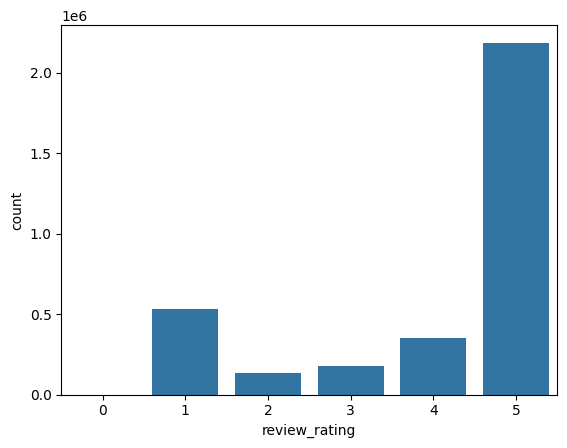

In [14]:
sns.countplot(data = df, x='review_rating')

In [15]:
# Count the number of rows where review_rating is 1
rating_1_count = (df['review_rating'] == 1).sum()
rating_2_count = (df['review_rating'] == 2).sum()
rating_3_count = (df['review_rating'] == 3).sum()
rating_4_count = (df['review_rating'] == 4).sum()
rating_5_count = (df['review_rating'] == 5).sum()

print(f"Number of rows with review_rating equal to 1: {rating_1_count}")
print(f"Number of rows with review_rating equal to 2: {rating_2_count}")
print(f"Number of rows with review_rating equal to 3: {rating_3_count}")
print(f"Number of rows with review_rating equal to 4: {rating_4_count}")
print(f"Number of rows with review_rating equal to 5: {rating_5_count}")

Number of rows with review_rating equal to 1: 530849
Number of rows with review_rating equal to 2: 133334
Number of rows with review_rating equal to 3: 178543
Number of rows with review_rating equal to 4: 348881
Number of rows with review_rating equal to 5: 2185815


In [16]:
# Undersample 25% of the data for each rating level
rate_one = df[df['review_rating'] == 1].sample(n=int(rating_1_count * 0.15))
rate_two = df[df['review_rating'] == 2].sample(n=int(rating_2_count * 0.15))
rate_three = df[df['review_rating'] == 3].sample(n=int(rating_3_count * 0.15))
rate_four = df[df['review_rating'] == 4].sample(n=int(rating_4_count * 0.15))
rate_five = df[df['review_rating'] == 5].sample(n=int(rating_5_count * 0.15))

In [17]:
undersampled_df = pd.concat([rate_one, rate_two, rate_three, rate_four, rate_five])

print(f"Total rows after undersampling: {undersampled_df.shape[0]}")
undersampled_df.head(5)

Total rows after undersampling: 506612


,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
1480604,1db23aa2-d687-41c6-909d-4435e26d86e4,1.121512e+20,A Google user,the new version (june 2019) is almost impossib...,1,1,8.5.10.774,2019-06-19 13:00:26
1975267,09f74b33-1cbc-49cf-9d6d-384239898f6c,3.224024e+20,Sh*********ma,It takes so much data,1,0,nan,2020-08-25 11:44:37
2822348,5d1fc81a-6716-424c-9753-1f021ada941a,2.186365e+20,Lu**********do,MGA BOBO NAKA SHUFFLE MGA KANTA D KO NA TO I D...,1,0,nan,2022-08-28 03:50:34
2273526,1053a256-350c-4d61-89a2-222947f93cf1,1.320840e+20,Ka********di,Don't ever try,1,0,nan,2021-05-07 06:28:03
2983639,c9b3caf6-122b-4a8a-80e5-43e77435b9f8,2.079438e+20,Ma**********ld,I've uninstalled this app. Just keeps stopping...,1,0,8.8.8.548,2023-02-21 06:44:33


<Axes: xlabel='review_rating', ylabel='count'>

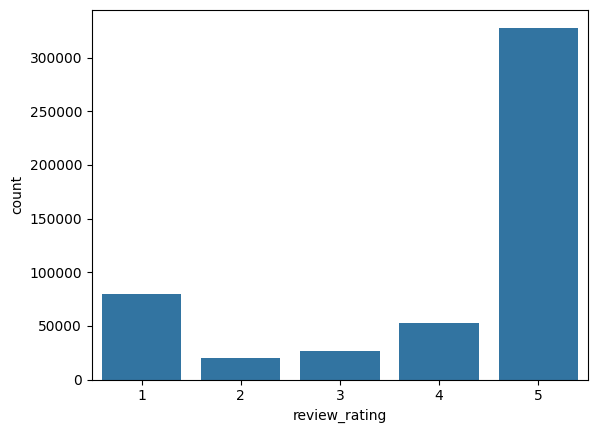

In [18]:
sns.countplot(data = undersampled_df, x='review_rating')

In [19]:
def categorize_review(text):
    text_lower = text.lower()
    tags = []

    # Check for positive and negative sentiment keywords
    if any(keyword in text_lower for keyword in ['love', 'like', 'great', 'excellent', 'amazing']):
        tags.append('positive')
    if any(keyword in text_lower for keyword in ['dislike', 'hate', 'bad', 'poor', 'terrible']):
        tags.append('negative')

    # Check for feature mentions
    if any(keyword in text_lower for keyword in ['ui', 'design', 'interface']):
        tags.append('ui')
    if any(keyword in text_lower for keyword in ['music variety', 'song selection', 'playlist']):
        tags.append('music_variety')
    if any(keyword in text_lower for keyword in ['recommendation', 'personalized', 'algorithm']):
        tags.append('recommendation')

    # Check for comparisons with competitors
    if 'compare' in text_lower or 'comparison' in text_lower:
        tags.append('comparison')
    if 'pandora' in text_lower:
        tags.append('competitor_pandora')
    if 'apple music' in text_lower:
        tags.append('competitor_apple_music')
    if 'amazon music' in text_lower:
        tags.append('competitor_amazon_music')

    # Check for trends and other insights
    if any(keyword in text_lower for keyword in ['trend', 'pattern', 'demand', 'popular']):
        tags.append('trend')

    # Default to 'general' if no specific tags are found
    if not tags:
        tags.append('general')

    return ', '.join(tags)

In [20]:
# Apply the tagging function to the dataframe
undersampled_df['tags'] = undersampled_df['review_text'].apply(categorize_review)

In [21]:
# Langchain documentation: 
# Intanstiate and run the dataframe loader to load the documents. You must include the column name that has the text
#https://python.langchain.com/docs/modules/data_connection/document_loaders/
loader = DataFrameLoader(undersampled_df, 'review_text')
docs = loader.load()

In [22]:
docs[0].metadata.keys()

dict_keys(['review_id', 'pseudo_author_id', 'author_name', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'tags'])

In [23]:
for i, doc in enumerate(docs):
    doc.metadata['tags'] = undersampled_df.iloc[i]['tags']

In [24]:
# Split the transcripts into smaller chunks
# https://python.langchain.com/docs/modules/data_connection/document_transformers/
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [25]:
len(docs)

506612

In [26]:
len(splits)

506866

In [27]:
splits[0]

Document(page_content='the new version (june 2019) is almost impossibly bad and takes forever to load/find any of my music', metadata={'review_id': '1db23aa2-d687-41c6-909d-4435e26d86e4', 'pseudo_author_id': 1.1215116614876342e+20, 'author_name': 'A Google user', 'review_rating': 1, 'review_likes': 1, 'author_app_version': '8.5.10.774', 'review_timestamp': '2019-06-19 13:00:26', 'tags': 'negative'})

In [28]:
# Create and persist a Chroma vector store
# https://python.langchain.com/docs/modules/data_connection/vectorstores/
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings_model, persist_directory="chroma_data")

# Step 3: Test it out with some queries!

In [29]:
# Read it back from disk just to make sure it is working properly
vectorstore2 = Chroma(persist_directory="chroma_data", embedding_function=embeddings_model)

In [30]:
# Create a test query
query = "feature"
k = 10
results = vectorstore2.similarity_search_with_relevance_scores(query, k=k)
# Print out just the video titles
[(r[0].metadata['review_rating'], r[1]) for r in results]

[(5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015),
 (5, 0.7367459583868015)]

In [31]:
# Create the "retreiver", including how many results you want it to produce
# Will be using this in the rag "chain" we are going to create so let's just make sure it is working as expected
# https://python.langchain.com/docs/modules/data_connection/retrievers/vectorstore/
retriever = vectorstore2.as_retriever(search_kwargs={"k":k})

In [32]:
# Run a test
results = retriever.invoke(query)
[r.metadata['review_rating'] for r in results]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [33]:
len(results)

10

In [34]:
results

[Document(page_content='great', metadata={'author_app_version': '8.5.1.734', 'author_name': 'A Google user', 'pseudo_author_id': 3.118741810976022e+20, 'review_id': '4dbab66b-675c-48aa-af40-12be9b1c396e', 'review_likes': 0, 'review_rating': 5, 'review_timestamp': '2019-04-26 16:15:42', 'tags': 'positive'}),
 Document(page_content='great', metadata={'author_app_version': '8.5.68.904', 'author_name': 'ar********ao', 'pseudo_author_id': 1.3309685762912728e+20, 'review_id': 'be600930-bb37-4911-ac77-6261530a0de9', 'review_likes': 0, 'review_rating': 5, 'review_timestamp': '2020-07-29 10:56:32', 'tags': 'positive'}),
 Document(page_content='great', metadata={'author_app_version': '8.4.91.861', 'author_name': 'A Google user', 'pseudo_author_id': 3.096938379149186e+20, 'review_id': 'c80cbeb8-f303-4ead-9a54-aa9cf717d955', 'review_likes': 0, 'review_rating': 5, 'review_timestamp': '2019-02-06 23:41:19', 'tags': 'positive'}),
 Document(page_content='great', metadata={'author_app_version': '8.4.89